In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.special import erf
from scipy.signal import welch

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analyss_notebooks/../analysis_utils.py'>

In [104]:
c = 299792458  # m/s
SI2ev = (1 / 1.6e-19) * c

In [3]:
def get_unnormalized_amps(data_files, 
                          noise=False,
                          no_search=False,
                          positive_pulse=True,
                          notch_freq=119000,
                          passband=(30000, 80000),
                          analysis_window_length=50000,
                          prepulse_window_length=50000,
                          search_window_length=250,
                          search_offset_length=20,
                          lowpass_freq=80000
                          ):
    amps = []
    for file in data_files:
        dtt, nn = utils.load_timestreams(file, ['D', 'G'])
        fs = int(np.ceil(1 / dtt))
        zz, dd = nn[0], nn[1]

        if notch_freq is not None:
            zz = utils.notch_filtered(zz, fs, f0=119000, q=50)

        bandpass_lb, bandpass_ub = passband
        zz_bp = utils.bandpass_filtered(zz, fs, bandpass_lb, bandpass_ub)

        trigger_level = positive_pulse * 0.5
        pulse_idx = utils.get_pulse_idx(dd, trigger_level, positive_pulse)
        
        if noise:
            # Fit noise away from the pulses
            pulse_idx = np.ceil(0.5 * (pulse_idx[:-1] + pulse_idx[1:])).astype(np.int64)

        for i, idx in enumerate(pulse_idx):
            if idx < prepulse_window_length:
                print('Skipping pulse too close to the beginning of file')
                continue
            if idx > (zz.size - analysis_window_length):
                print('Skipping pulse too close to the end of file')
                continue

            # 20241205: use a much narrower search window (25 indices; 5 us)
            # 20250211: change window length to 50000 indices and search window to 50 us
            # to be consistent with DM search
            window, f, f_lp, amp = utils.recon_pulse(idx, dtt, zz_bp, dd, 
                                               analysis_window_length, 
                                               prepulse_window_length, 
                                               search_window_length, 
                                               search_offset_length,
                                               lowpass_freq)

            if noise:
                if np.isnan(amp):
                    pass
                elif no_search:
                    # If no search, just take th middle value
                    amps.append(np.abs(f_lp[np.ceil(f_lp.size/2).astype(np.int64)])/1e9)
                else:
                    amps.append(amp)
            else:
                amps.append(amp)

    amps = np.asarray(amps)
    return amps

In [113]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

def voigt(xx, A, x0, sigma, gamma):
    return A * voigt_profile(xx-x0, sigma, gamma)

def fit_sigma_voigt(ff, sz, gamma=None):
    fit_idx_voigt = np.logical_and(ff > 27000, ff < 33000)

    popt, pcov = curve_fit(lambda xx, A, f0, sigma, gamma: voigt(xx, A, f0, sigma, gamma), ff[fit_idx_voigt]*2*np.pi, sz[fit_idx_voigt], 
                           p0=[4e-17, 30500*2*np.pi, 50*2*np.pi, 1*2*np.pi], sigma=sz[fit_idx_voigt])
    
    # If don't want to fit for gamma
    # popt, pcov = curve_fit(lambda xx, A, f0, sigma: voigt(xx, A, f0, sigma, gamma), ff[fit_idx_voigt]*2*np.pi, sz[fit_idx_voigt], 
    #                        p0=[1e-18, 50000*2*np.pi, 43*2*np.pi], sigma=sz[fit_idx_voigt])
    
    return popt

In [114]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_convolved_lineshape(omega, A, omega0, sigma, gamma):
    xx_gauss = np.arange(-400*2*np.pi, 400*2*np.pi, 1)
    gauss_kernel = gauss(xx_gauss, A=1, mu=0, sigma=sigma)
    gauss_kernel /= np.sum(gauss_kernel)

    xx = np.arange(20000*2*np.pi, 120000*2*np.pi, 1)
    actual_lineshape = A / ((xx**2 - omega0**2)**2 + gamma**2 * xx**2)
    
    convolved_lineshape = np.convolve(gauss_kernel, actual_lineshape, 'same')
    return np.interp(omega, xx, convolved_lineshape)

#### Calibrate the PSD into physical units

In [66]:
_file = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_2.hdf5'
dtt, nn = utils.load_timestreams(_file, ['D'])
fs = int(np.ceil(1 / dtt))
zz = nn[0]

m = 2000 * (83e-9**3) * (4/3) * np.pi  # sphere mass
ff, pp = welch(zz, fs, nperseg=2**16)

efield = 79 # V/m (when 1 V is applied to lens holder 2) 
charge = 10
vpp    = 10
passband = (72500, 73500)
omegad = 73000 * 2 * np.pi

fd0 = (vpp / 2) * efield * charge * 1.6e-19
v2_drive = utils.get_area_driven_peak(ff, pp, passband=passband, noise_floor=0, plot=False)

idx_band = np.logical_and(ff > 20000, ff < 40000)
omega0 = 2 * np.pi * ff[idx_band][np.argmax(pp[idx_band])]
z2_drive = (fd0**2 / 2) / ((m * (omega0**2 - omegad**2))**2)

c_cal = v2_drive / z2_drive
c_mv = np.sqrt(1 / c_cal)

In [ ]:
_file = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_nodrive_3.hdf5'
dtt, nn = utils.load_timestreams(_file, ['D'])
fs = int(np.ceil(1 / dtt))
zz = nn[0]

ff, pp = welch(zz, fs, nperseg=2**17)

In [ ]:
sz_measured = pp * c_mv**2
A, omega0, sigma, gamma_voigt = fit_sigma_voigt(ff, sz_measured)

Text(0, 0.5, '$\\bar{S}_z$ (m$^2$/Hz)')

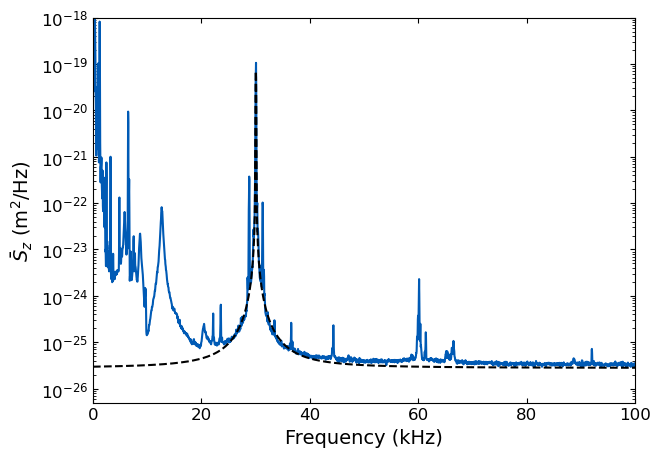

In [110]:
sz_measured = pp * c_mv**2
omega = ff * 2 * np.pi

fit_idx = np.logical_and(ff > 250000, ff < 270000)
sz_noisefloor = np.mean(sz_measured[fit_idx])

plt.plot(ff/1000, pp*c_mv**2, color='#005AB5')
plt.plot(ff/1000, (voigt(omega, A, omega0, sigma, gamma_voigt) + sz_noisefloor), 'k--', label='Voigt fit')

plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(5e-27, 1e-18)

plt.xlabel('Frequency (kHz)')
plt.ylabel(r'$\bar{S}_z$ (m$^2$/Hz)')

In [109]:
gamma = gamma_voigt * 2

# Use the sigma and gamma extracted from voigt fit
# to calculate the broadend lineshape
# gamma/2 is the corresponding Lorentzian linewidth if the true oscillator
# had damping gamma
convolved_lineshape = gaussian_convolved_lineshape(ff*2*np.pi, 1, omega0, sigma, gamma)
chi_2_convolved = (1 / (m**2)) * convolved_lineshape

sf_measured_convolved = sz_measured / (chi_2_convolved)

idx_int = np.logical_and(ff>20000, ff<50000)
dp_kev = np.sqrt( 1/( np.trapz(4/sf_measured_convolved[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000

print(f'Predicted impulse sensitivity: {dp_kev:.3f} keV/c')

Predicted impulse sensitivity: 118.590 keV/c


(1e-21, 1e-17)

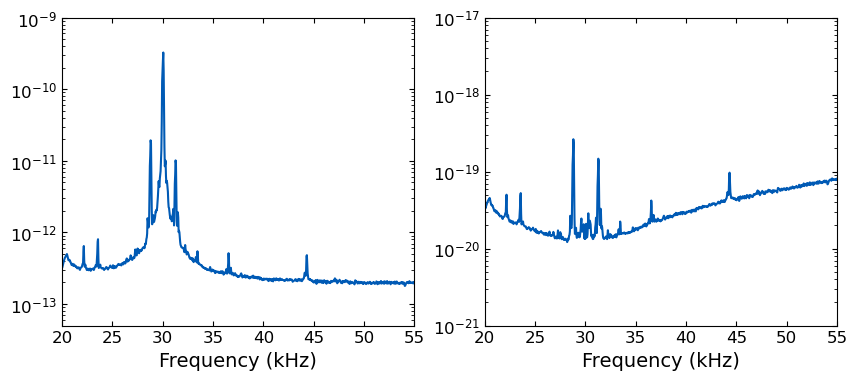

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(ff/1000, np.sqrt(sz_measured), color='#005AB5')
axes[1].plot(ff/1000, np.sqrt(sf_measured_convolved), color='#005AB5')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(20, 55)
    ax.set_xlabel('Frequency (kHz)')

axes[0].set_ylim(5e-14, 1e-9)
axes[1].set_ylim(1e-21, 1e-17)

In [131]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_p10e_5e-8mbar_30khz_d93khz_0'
data_prefix = '20250910_dfg_p10e_200ns_'
voltages = [5, 10, 15, 20]

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=93000,
                            passband=(20000, 50000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20,
                            lowpass_freq=50000
                            )

    if v == 5:
        amps_noise = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=93000,
                        passband=(20000, 50000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20,
                        lowpass_freq=50000
                        )
            
    amps_all.append(np.asarray(amps))

5
Skipping pulse too close to the beginning of file
10
15
Skipping pulse too close to the beginning of file
20


In [135]:
pulse_amps_1e = np.asarray([34, 80, 127, 174])
pulse_amp = pulse_amps_1e * 10

bins = np.arange(0,3000, 50) / 61721.2989069973
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

Text(0, 0.5, 'Counts/(50 keV/$c$)')

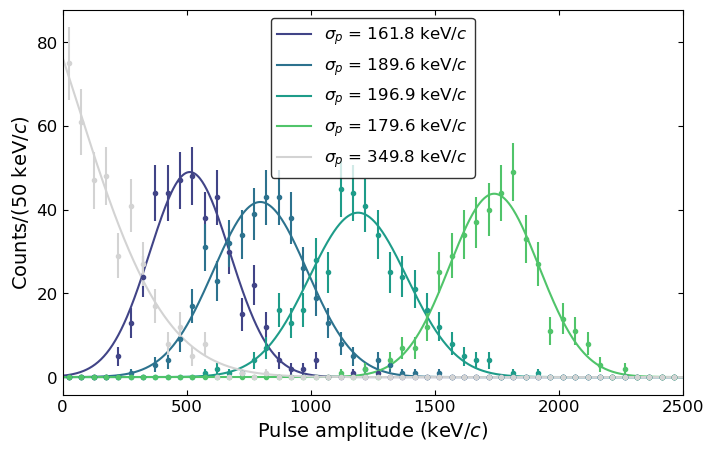

In [159]:
plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 5))
for i in range(4):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.xlim(0, 2500)
plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')

In [139]:
amps_all[3]

array([0.03026011, 0.02941163, 0.03063829, 0.03424962, 0.02479681,
       0.02924331, 0.03087692, 0.02394749, 0.02954589, 0.02528257,
       0.02819764, 0.03167037, 0.02834965, 0.02729441, 0.02799531,
       0.02833428, 0.02944541, 0.0287663 , 0.0288582 , 0.03376147,
       0.02816764, 0.0254672 , 0.03042593, 0.02644724, 0.02946279,
       0.02581819, 0.02594701, 0.02796565, 0.03001103, 0.02523863,
       0.02843857, 0.02570501, 0.03059799, 0.02418029, 0.028063  ,
       0.02965955, 0.02666265, 0.0243948 , 0.02244444, 0.03284421,
       0.02874651, 0.03280355, 0.02713592, 0.02635934, 0.02681345,
       0.03096622, 0.02504074, 0.02799117, 0.02407664, 0.0277214 ,
       0.02742849, 0.02591153, 0.02603592, 0.02646272, 0.02943533,
       0.02829261, 0.02488448, 0.02836167, 0.02988191, 0.02870462,
       0.02851858, 0.02823882, 0.02567289, 0.0234628 , 0.02760879,
       0.03153876, 0.02765764, 0.02698698, 0.02724429, 0.02820249,
       0.02857876, 0.03376112, 0.02644182, 0.0336177 , 0.03048

In [140]:
from scipy.signal import butter, sosfilt

def demodulate(_sig, _lo, f_samp, f_lp):
    mixed_sig = _sig * _lo

    sos = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=f_samp)
    filtered = sosfilt(sos, mixed_sig)
    
    return filtered

In [ ]:
tone_level = []
res_freq = []
for i in range(2):
    _file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_p10e_5e-8mbar_30khz_d93khz_0/20250910_dfg_p10e_200ns_20v_{i}.hdf5'

    dtt, nn = utils.load_timestreams(_file, ['D', 'F', 'G'])
    fs = int(np.ceil(1 / dtt))
    zz, ff, dd = nn[0], nn[1], nn[2]

    positive_pulse = True
    trigger_level = positive_pulse * 0.5
    pulse_idx = utils.get_pulse_idx(dd, trigger_level, positive_pulse)

    ee = demodulate(zz, ff, fs, 20)
    tone_level.append(ee[pulse_idx])

tone_level = np.asarray(tone_level).flatten()

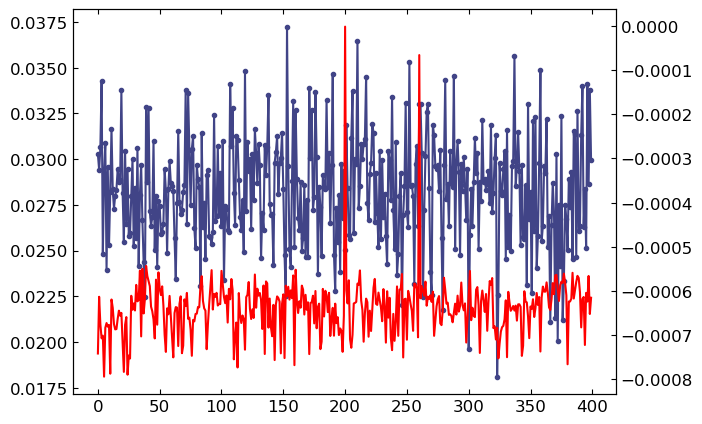

In [156]:
plt.plot(amps_all[3], '.-')
plt.twinx().plot(tone_level, 'r')

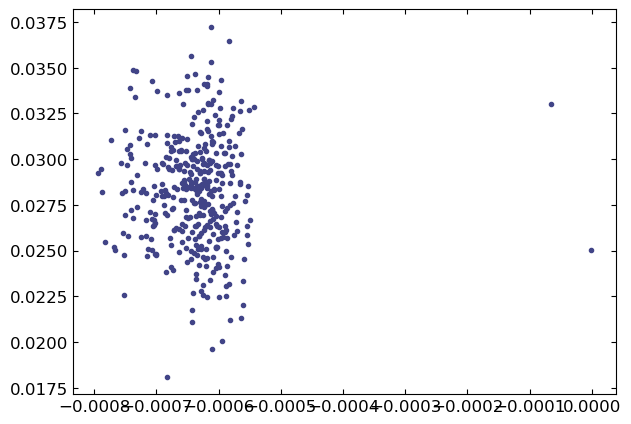

In [150]:
plt.plot(tone_level, amps_all[3], '.')